In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os


In [2]:
# Define base paths
data_dir = "../../data/loaded"
Images_dir = "../../images/process_2"
processed_data_dir = "../../data/processed"
fire_file_path = os.path.join(data_dir, "fire.csv")

In [3]:
fire_df = pd.read_csv(fire_file_path)

# 1- Keep only rows where type=0

In [4]:
## keep only rows where type=0
fire_df_0 = fire_df[fire_df['type'] == 0]
fire_df_0.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,country
5,35.70751,5.53337,312.32,0.45,0.39,2024-01-01,141,N20,VIIRS,n,2,268.88,1.25,N,0,Algeria
13,32.13579,6.46961,326.80,0.56,0.43,2024-01-01,142,N20,VIIRS,n,2,279.44,5.52,N,0,Algeria
20,32.35563,6.97630,341.76,0.39,0.44,2024-01-01,142,N20,VIIRS,n,2,280.66,10.25,N,0,Algeria
64,28.19791,9.39581,327.82,0.33,0.55,2024-01-01,143,N20,VIIRS,n,2,277.00,1.44,N,0,Algeria
67,28.12826,9.49323,308.57,0.33,0.55,2024-01-01,143,N20,VIIRS,n,2,278.63,0.85,N,0,Algeria


In [5]:
print("original rows:", len(fire_df))
print("rows with type=0:", len(fire_df_0))
print("removed rows (percentage):", (len(fire_df) - len(fire_df_0)) / len(fire_df) * 100)

original rows: 90250
rows with type=0: 14216
removed rows (percentage): 84.24819944598339


In [6]:
fire_df_0.columns

Index(['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_ti5', 'frp', 'daynight', 'type', 'country'],
      dtype='object')

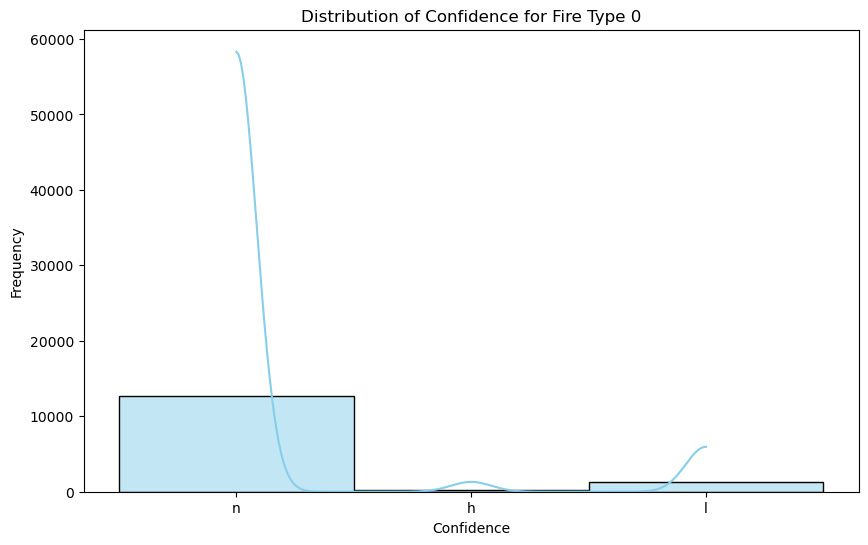

In [7]:
# plot distribution of confidence column
plt.figure(figsize=(10, 6))
sns.histplot(fire_df_0['confidence'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Confidence for Fire Type 0')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Images_dir, 'confidence_distribution_type_0.png'))

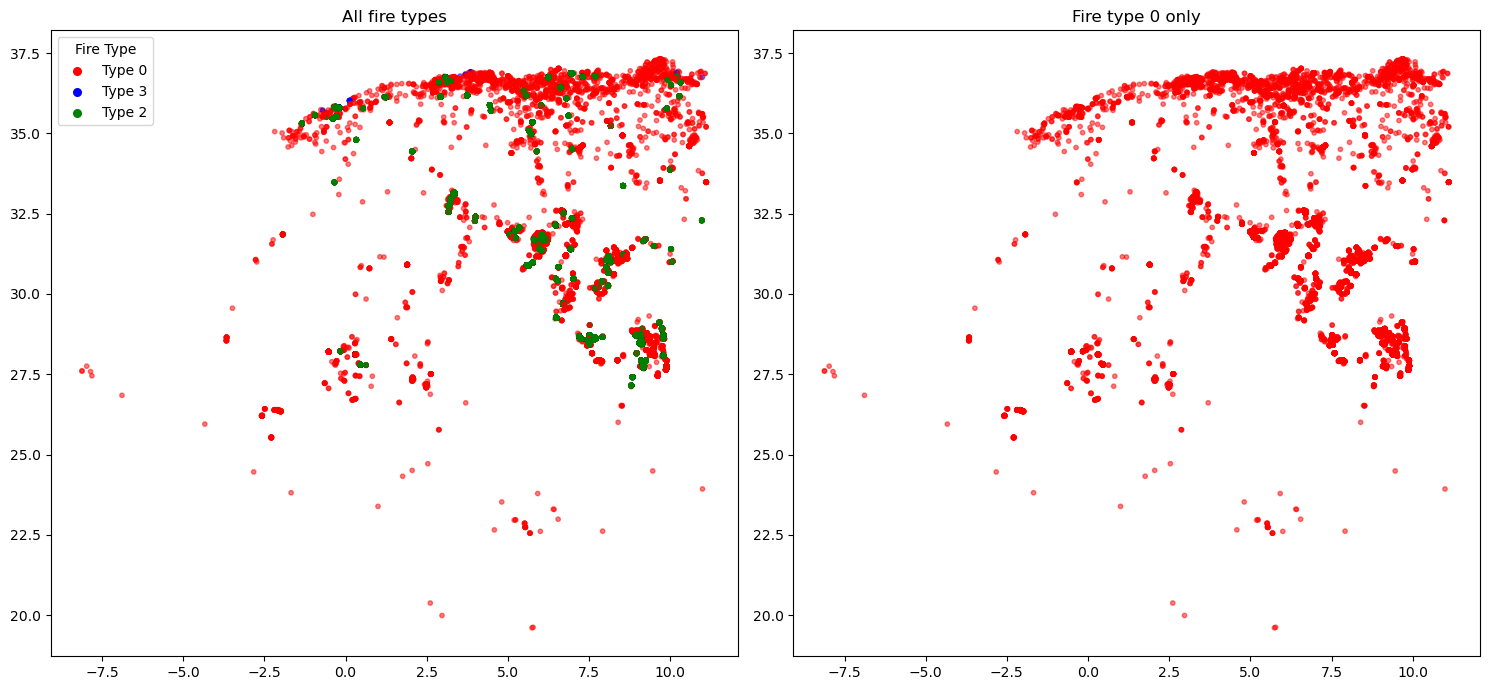

In [128]:
color_dict = {0: 'red', 3: 'blue', 2: 'green'}
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].scatter(fire_df['longitude'], fire_df['latitude'], c=fire_df['type'].map(color_dict), alpha=0.5, s=10)
axes[0].set_title('All fire types')
for t, c in color_dict.items():
    axes[0].scatter([], [], color=c, label=f'Type {t}', s=30)
axes[0].legend(title='Fire Type')
axes[1].scatter(fire_df_0['longitude'], fire_df_0['latitude'], c=fire_df_0['type'].map(color_dict), alpha=0.5, s=10)
axes[1].set_title('Fire type 0 only')
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "fire_type_filtering.png"))
plt.show()


# 2- remove unecessary columns

In [6]:
# keep only longitude and latitude columns
fire_new = fire_df_0[['longitude', 'latitude']].drop_duplicates().reset_index(drop=True)
fire_new.head()

,longitude,latitude
0,5.53337,35.70751
1,6.46961,32.13579
2,6.97630,32.35563
3,9.39581,28.19791
4,9.49323,28.12826


In [7]:
# remove duplicates
# nb duplicates before
print("Number of unique lon/lat pairs before removing duplicates:", len(fire_new))
fire_new = fire_new.drop_duplicates().reset_index(drop=True)
# nb duplicates after
print("Number of unique lon/lat pairs after removing duplicates:", len(fire_new))

Number of unique lon/lat pairs before removing duplicates: 14210
Number of unique lon/lat pairs after removing duplicates: 14210


In [8]:
print("original nb cols:", len(fire_df_0.columns))
print("cleaned nb cols:", len(fire_new.columns))

original nb cols: 16
cleaned nb cols: 2


# 3- add class 0

In [9]:
# print ranges of lon and lat
print("Longitude range:", fire_new['longitude'].min(), "to", fire_new['longitude'].max())
print("Latitude range:", fire_new['latitude'].min(), "to", fire_new['latitude'].max())

Longitude range: -8.11805 to 11.11035
Latitude range: 19.60323 to 37.32346


## use landcover

In [10]:
land_file_path = os.path.join(data_dir, "landcover.csv")
land_df = pd.read_csv(land_file_path)
land_df.head()

,ID,GRIDCODE,AREA_M2,LCCCode,geometry
0,4,210,6.228187e+06,7001 // 8001,POLYGON ((6.415277779717008 37.086959465484505...
1,2,210,6.242408e+06,7001 // 8001,POLYGON ((7.180840924329724 37.079166666715295...
2,1,210,1.482995e+06,7001 // 8001,"POLYGON ((7.371374609418377 37.0819444444929, ..."
3,8,50,4.590841e+08,21497-121340,"POLYGON ((6.123611113048653 36.68472222226833,..."
4,13,210,6.371533e+06,7001 // 8001,"POLYGON ((6.261814820345212 37.02361111115902,..."


In [11]:
# use wkt to create geometries
from shapely import wkt
land_df['geometry'] = land_df['geometry'].apply(wkt.loads)
land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry')  # use existing polygon geometry
land_gdf.set_crs(epsg=4326, inplace=True)  # make sure CRS is set

# Get bounding box of all land polygons
land_bounds = land_gdf.total_bounds  # returns (minx, miny, maxx, maxy)
print("Landcover polygons bounds (minx, miny, maxx, maxy):", land_bounds)


Landcover polygons bounds (minx, miny, maxx, maxy): [-8.67386723 18.96002769 11.97954845 37.54393005]


In [12]:
minx = -8.67386723
miny = 18.96002769
maxx = 11.97954845
maxy = 37.54393005


### generate grid

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -------------------------
# Parameters
# -------------------------
minx, miny = -8.67386723, 18.96002769
maxx, maxy = 11.97954845, 37.54393005   # use full latitude, NO CUTOFF

#  1000 m spacing
spacing_m = 4000
dlat = spacing_m / 111320                     # ~0.009 degrees
dlon = spacing_m / (111320 * np.cos(np.deg2rad(33)))  # ~0.0106 degrees

chunk_size_deg = 1.0  # latitude chunk size

# Generate full longitude range
lon_vals = np.arange(minx, maxx + dlon, dlon)

# -------------------------
# Initialize list to collect all chunks
# -------------------------
all_chunks = []

# Process latitude in chunks
lat_start = miny
chunk_idx = 0
while lat_start < maxy:
    lat_end = min(lat_start + chunk_size_deg, maxy)
    print(f"Processing chunk {chunk_idx}: lat {lat_start:.5f} → {lat_end:.5f}")
    
    lat_vals = np.arange(lat_start, lat_end + dlat, dlat)
    
    # Create meshgrid
    lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
    grid_points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
    
    # Convert to GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(
        pd.DataFrame(grid_points, columns=['longitude', 'latitude']),
        geometry=[Point(xy) for xy in grid_points],
        crs="EPSG:4326"
    )
    
    # Clip with land polygons
    grid_clipped = gpd.sjoin(grid_gdf, land_gdf, predicate="within", how="inner")
    grid_clipped = grid_clipped[['longitude', 'latitude', 'geometry']].copy()
    
    # Assign fire=0
    grid_clipped['fire'] = 0
    
    all_chunks.append(grid_clipped)
    
    # Next chunk
    lat_start += chunk_size_deg
    chunk_idx += 1

# -------------------------
# Combine all chunks
# -------------------------
grid_full = pd.concat(all_chunks, ignore_index=True)
print("Total points after clipping:", len(grid_full))


Processing chunk 0: lat 18.96003 → 19.96003
Processing chunk 1: lat 19.96003 → 20.96003
Processing chunk 2: lat 20.96003 → 21.96003
Processing chunk 3: lat 21.96003 → 22.96003
Processing chunk 4: lat 22.96003 → 23.96003
Processing chunk 5: lat 23.96003 → 24.96003
Processing chunk 6: lat 24.96003 → 25.96003
Processing chunk 7: lat 25.96003 → 26.96003
Processing chunk 8: lat 26.96003 → 27.96003
Processing chunk 9: lat 27.96003 → 28.96003
Processing chunk 10: lat 28.96003 → 29.96003
Processing chunk 11: lat 29.96003 → 30.96003
Processing chunk 12: lat 30.96003 → 31.96003
Processing chunk 13: lat 31.96003 → 32.96003
Processing chunk 14: lat 32.96003 → 33.96003
Processing chunk 15: lat 33.96003 → 34.96003
Processing chunk 16: lat 34.96003 → 35.96003
Processing chunk 17: lat 35.96003 → 36.96003
Processing chunk 18: lat 36.96003 → 37.54393
Total points after clipping: 154618


In [14]:
grid_full.head()

,longitude,latitude,geometry,fire
0,3.322601,18.99596,POINT (3.3226 18.99596),0
1,3.365446,18.99596,POINT (3.36545 18.99596),0
2,3.408290,18.99596,POINT (3.40829 18.99596),0
3,3.451135,18.99596,POINT (3.45113 18.99596),0
4,3.493980,18.99596,POINT (3.49398 18.99596),0


### merge to get full data

In [15]:
# make fire_cropped gdf
fire_new_gdf = gpd.GeoDataFrame(
    fire_new,
    geometry=[Point(xy) for xy in zip(fire_new['longitude'], fire_new['latitude'])],
    crs="EPSG:4326"
)


In [16]:
fire_new_gdf.head()

,longitude,latitude,geometry
0,5.53337,35.70751,POINT (5.53337 35.70751)
1,6.46961,32.13579,POINT (6.46961 32.13579)
2,6.97630,32.35563,POINT (6.9763 32.35563)
3,9.39581,28.19791,POINT (9.39581 28.19791)
4,9.49323,28.12826,POINT (9.49323 28.12826)


In [17]:
# take 5 decimals in longitude and latitude
grid_full['longitude'] = grid_full['longitude'].round(5)
grid_full['latitude'] = grid_full['latitude'].round(5)

In [18]:
# Make sure fire points have same columns as grid
fire_points = fire_new_gdf[['longitude', 'latitude']].copy()
fire_points['fire'] = 1
grid_full['fire'] = 0  # all grid points initially 0
# Concatenate
combined = pd.concat([grid_full, fire_points], ignore_index=True)


In [19]:
# Sort so that fire=1 comes first 
combined = combined.sort_values('fire', ascending=False)
# Drop duplicates based on lat/lon
combined = combined.drop_duplicates(subset=['longitude','latitude'], keep='first')
# Reset index
combined = combined.reset_index(drop=True)


In [20]:
# print stat
print("Total points in full dataset:", len(combined))
print("Class distribution:\n", combined['fire'].value_counts())


Total points in full dataset: 168828
Class distribution:
 fire
0    154618
1     14210
Name: count, dtype: int64


In [21]:
print("distribution percentage", combined['fire'].value_counts(normalize=True) * 100)

distribution percentage fire
0    91.58315
1     8.41685
Name: proportion, dtype: float64


In [22]:
# drop geometry
combined = combined.drop(columns=['geometry'])
combined.head()

,longitude,latitude,fire
0,10.10370,36.72831,1
1,10.10462,36.73183,1
2,9.68184,33.53246,1
3,9.27448,33.45376,1
4,10.28045,36.16274,1


# 5- Clip

C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\1915393755.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fires_per_bin = combined.groupby('lat_bin')['fire'].sum()
C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\1915393755.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_bin = combined.groupby('lat_bin')['fire'].count()
C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\1915393755.py:20: RuntimeWarning: invalid value encountered in divide
  fire_density = fires / total
C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\1915393755.py:47: RuntimeWarning: invalid value encountered in scalar div

Lower cutoff = 37.5010
Upper cutoff = 32.1210
Fires = 0
Non-fires = 0
Ratio = nan


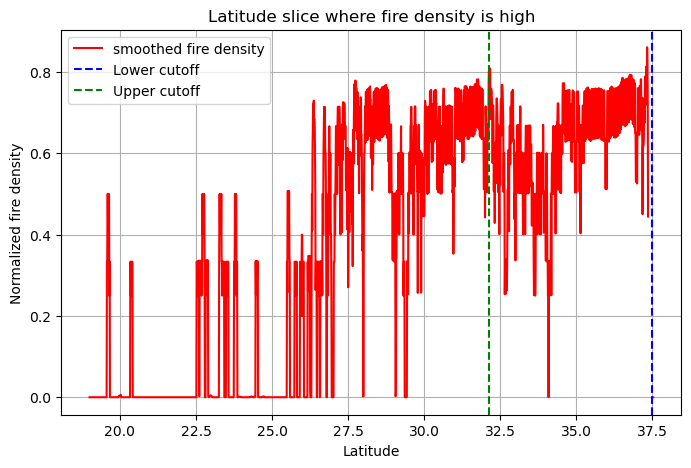

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Latitude binning
bin_size = 0.01
lat_bins = np.arange(combined['latitude'].min(),
                     combined['latitude'].max() + bin_size,
                     bin_size)
combined['lat_bin'] = pd.cut(combined['latitude'], bins=lat_bins)

fires_per_bin = combined.groupby('lat_bin')['fire'].sum()
total_per_bin = combined.groupby('lat_bin')['fire'].count()

bin_mids = np.array([interval.mid for interval in fires_per_bin.index])
fires = fires_per_bin.values
total = total_per_bin.values

# 2. Compute normalized fire density
fire_density = fires / total

# smooth density
fire_density_smooth = pd.Series(fire_density).rolling(window=8, min_periods=1, center=True).mean().values

# 3. Threshold for low fire density ( 10% of points are fire)
density_threshold = 0.8

# 4. Lower cutoff (scan from south to north)
for i in range(len(bin_mids)):
    if fire_density_smooth[i] < density_threshold and fire_density_smooth[i:].max() < density_threshold:
        lat_lower_cutoff = bin_mids[i]
        break
else:
    lat_lower_cutoff = bin_mids[0]

# 5. Upper cutoff (scan from north to south)
for i in reversed(range(len(bin_mids))):
    if fire_density_smooth[i] < density_threshold and fire_density_smooth[:i+1].max() < density_threshold:
        lat_upper_cutoff = bin_mids[i]
        break
else:
    lat_upper_cutoff = bin_mids[-1]

# 6. Report
fires_in = fires[(bin_mids >= lat_lower_cutoff) & (bin_mids <= lat_upper_cutoff)].sum()
nofires_in = total[(bin_mids >= lat_lower_cutoff) & (bin_mids <= lat_upper_cutoff)].sum() - fires_in
actual_ratio = nofires_in / fires_in

print(f"Lower cutoff = {lat_lower_cutoff:.4f}")
print(f"Upper cutoff = {lat_upper_cutoff:.4f}")
print(f"Fires = {fires_in}")
print(f"Non-fires = {nofires_in}")
print(f"Ratio = {actual_ratio:.4f}")

# 7. Plot
plt.figure(figsize=(8,5))
plt.plot(bin_mids, fire_density_smooth, color='red', label='smoothed fire density')
plt.axvline(lat_lower_cutoff, color='blue', linestyle='--', label='Lower cutoff')
plt.axvline(lat_upper_cutoff, color='green', linestyle='--', label='Upper cutoff')
plt.xlabel("Latitude")
plt.ylabel("Normalized fire density")
plt.title("Latitude slice where fire density is high")
plt.legend()
plt.grid(True)
plt.show()


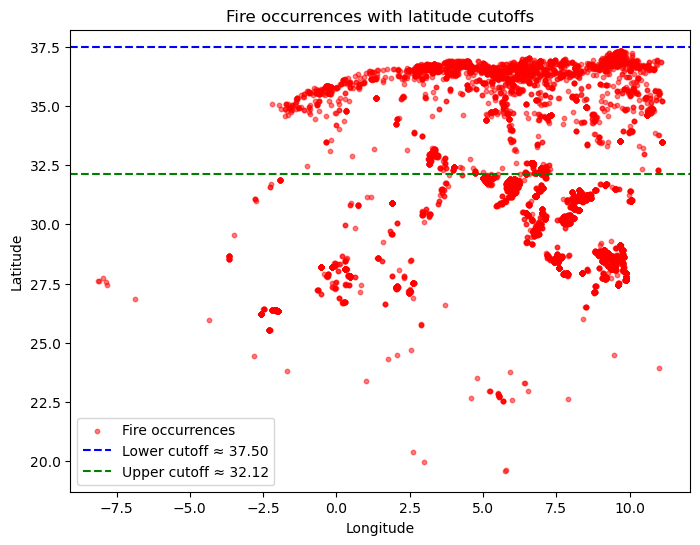

In [38]:
# plot scatter map with cutoffs
fire_points = combined[combined['fire'] == 1]
plt.figure(figsize=(8, 6))
plt.scatter(fire_points['longitude'], fire_points['latitude'], c='red', alpha=0.5, s=10, label='Fire occurrences')
plt.axhline(y=lat_lower_cutoff, color='blue', linestyle='--', label=f'Lower cutoff ≈ {lat_lower_cutoff:.2f}')
plt.axhline(y=lat_upper_cutoff, color='green', linestyle='--', label=f'Upper cutoff ≈ {lat_upper_cutoff:.2f}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire occurrences with latitude cutoffs')
plt.legend()
plt.savefig(os.path.join(Images_dir, "fire_occurrences_with_latitude_cutoffs.png"))
plt.show()

In [39]:
# max latitude in fire data
max_lat_fire = combined['latitude'].max()
print("Max latitude in fire data:", max_lat_fire)
# upper cutoff
print("lower latitude cutoff for fire activity:", lat_lower_cutoff)
print("Upper latitude cutoff for fire activity:", lat_upper_cutoff)

Max latitude in fire data: 37.53495
lower latitude cutoff for fire activity: 37.501000000000005
Upper latitude cutoff for fire activity: 32.120999999999995


In [40]:
# flip lower and upper cutoff if needed
if lat_lower_cutoff > lat_upper_cutoff:
    lat_lower_cutoff, lat_upper_cutoff = lat_upper_cutoff, lat_lower_cutoff
print("Adjusted lower latitude cutoff for fire activity:", lat_lower_cutoff)
print("Adjusted upper latitude cutoff for fire activity:", lat_upper_cutoff)


Adjusted lower latitude cutoff for fire activity: 32.120999999999995
Adjusted upper latitude cutoff for fire activity: 37.501000000000005


In [41]:
# crop data using upper cutoff and lower cutoff
fire_cropped = combined[(combined['latitude'] >= lat_lower_cutoff) & (combined['latitude'] <= lat_upper_cutoff)].reset_index(drop=True)
fire_cropped.head()

,longitude,latitude,fire,lat_bin
0,10.10370,36.72831,1,"(36.726, 36.736]"
1,10.10462,36.73183,1,"(36.726, 36.736]"
2,9.68184,33.53246,1,"(33.526, 33.536]"
3,9.27448,33.45376,1,"(33.446, 33.456]"
4,10.28045,36.16274,1,"(36.156, 36.166]"


In [42]:
# print min and max latitude in cropped data
print("Cropped data latitude range:", fire_cropped['latitude'].min(), "to", fire_cropped['latitude'].max())

Cropped data latitude range: 32.13063 to 37.32346


In [43]:
# fire distribution in cropped data
print("Class distribution in cropped data:\n", fire_cropped['fire'].value_counts())
# percentage
print("Class distribution percentage in cropped data:\n", fire_cropped['fire'].value_counts(normalize=True) * 100)


Class distribution in cropped data:
 fire
0    38262
1     4416
Name: count, dtype: int64
Class distribution percentage in cropped data:
 fire
0    89.652748
1    10.347252
Name: proportion, dtype: float64


C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\2427764145.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fires_per_bin = fire_cropped.groupby('lat_bin')['fire'].sum()
C:\Users\T14s\AppData\Local\Temp\ipykernel_19964\2427764145.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_bin = fire_cropped.groupby('lat_bin')['fire'].count()


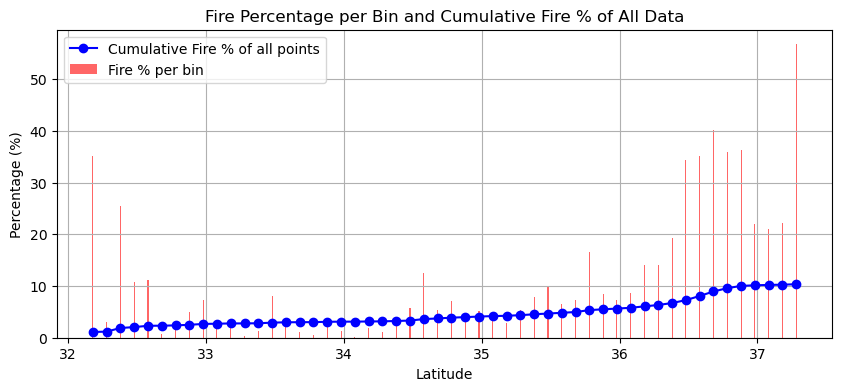

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Latitude bins
bin_size = 0.1
lat_bins = np.arange(fire_cropped['latitude'].min(),
                     fire_cropped['latitude'].max() + bin_size,
                     bin_size)
fire_cropped['lat_bin'] = pd.cut(fire_cropped['latitude'], bins=lat_bins)

# 2. Fire percentage per bin
fires_per_bin = fire_cropped.groupby('lat_bin')['fire'].sum()
total_per_bin = fire_cropped.groupby('lat_bin')['fire'].count()
fire_percentage = (fires_per_bin / total_per_bin) * 100  # % in bin

# 3. Cumulative fire percentage relative to all points
cumulative_fire_percentage = (fires_per_bin.cumsum() / len(fire_cropped)) * 100

# 4. Bin midpoints
bin_mids = np.array([interval.mid for interval in fires_per_bin.index])

# 5. Plot
plt.figure(figsize=(10, 4))

# Fire percentage per bin
plt.bar(bin_mids, fire_percentage, width=0.008, color='red', alpha=0.6, label='Fire % per bin')

# Cumulative fire percentage relative to all data
plt.plot(bin_mids, cumulative_fire_percentage, color='blue', marker='o', linestyle='-', label='Cumulative Fire % of all points')

plt.xlabel('Latitude')
plt.ylabel('Percentage (%)')
plt.title('Fire Percentage per Bin and Cumulative Fire % of All Data')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(Images_dir, "fire_percentage_cropped_data_distribution.png"))
plt.show()


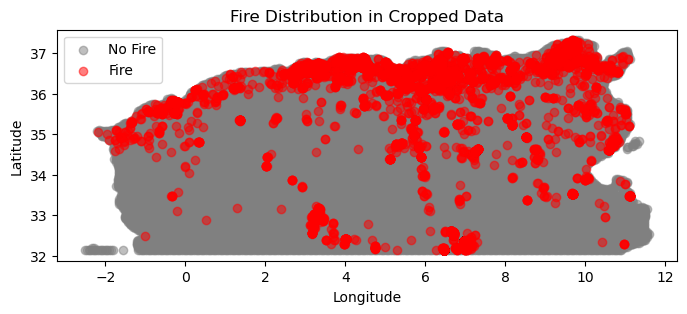

In [45]:
# plot cropped with no fire grey and fire red
plt.figure(figsize=(8, 3))
plt.scatter(fire_cropped[fire_cropped['fire'] == 0]['longitude'], fire_cropped[fire_cropped['fire'] == 0]['latitude'], color='grey', label='No Fire', alpha=0.5)
plt.scatter(fire_cropped[fire_cropped['fire'] == 1]['longitude'], fire_cropped[fire_cropped['fire'] == 1]['latitude'], color='red', label='Fire', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire Distribution in Cropped Data')
plt.legend()
plt.savefig(os.path.join(Images_dir, "fire_distribution_cropped_data.png"))
plt.show()

In [46]:
fire_cropped.shape

(42678, 4)

# 5- save 

In [47]:
# drop lat_bin col
fire_cropped = fire_cropped.drop(columns=['lat_bin'])

In [48]:
# save as parquet file
import pyarrow as pa
import pyarrow.parquet as pq

path = os.path.join(processed_data_dir, "fire.parquet")
fire_cropped.to_parquet(path, index=False)

# check 0 that are close to 1

In [49]:
path = os.path.join(processed_data_dir, "fire.parquet")
fire = pd.read_parquet(path)
fire.head()

,longitude,latitude,fire
0,10.10370,36.72831,1
1,10.10462,36.73183,1
2,9.68184,33.53246,1
3,9.27448,33.45376,1
4,10.28045,36.16274,1


In [50]:
print(fire["latitude"].min()," - ",fire["latitude"].max())

32.13063  -  37.32346


387 non-fire points REMOVED within 1000 meters of any fire point.
Removed non-fire points saved to: ../../data/processed\removed_no_fire_buffer1000.parquet
First 5 removed non-fire points:
     longitude  latitude  fire
169    5.29345  32.13969     0
192    6.27887  32.13969     0
196    6.45025  32.13969     0
204    6.79301  32.13969     0
441    4.73647  32.17562     0
[BUFFER] Saved: ../../data/processed\fire_buffer1000.parquet
[BUFFER] 1000m rows: 42291
[BUFFER] Percentage fire values:
fire
0    89.558062
1    10.441938


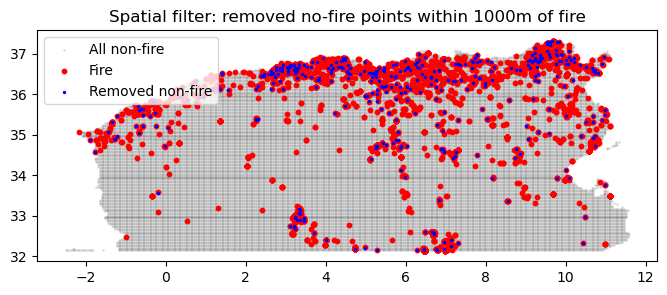

In [51]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import os



def latlon_to_ecef(lat, lon):
    # Spherical Earth ECEF in meters
    R = 6371000
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R * np.sin(lat)
    return np.column_stack((x, y, z))

fires = fire[fire.fire == 1].reset_index(drop=True)
no_fires = fire[fire.fire == 0].reset_index(drop=True)

for dist in [1000]:
    fire_xyz = latlon_to_ecef(fires.latitude.values, fires.longitude.values)
    tree = cKDTree(fire_xyz)

    no_fire_xyz = latlon_to_ecef(no_fires.latitude.values, no_fires.longitude.values)
    res = tree.query_ball_point(no_fire_xyz, r=dist)
    mask = np.array([len(hits) == 0 for hits in res])
    filtered_no_fires = no_fires[mask]

    # --- Non-fire points that are being REMOVED ---
    removed_no_fires = no_fires[~mask]
    n_removed = len(removed_no_fires)
    print(f"{n_removed} non-fire points REMOVED within {dist} meters of any fire point.")

    # Optionally save removed points
    removed_path = os.path.join(processed_data_dir, f"removed_no_fire_buffer{dist}.parquet")
    removed_no_fires.to_parquet(removed_path)
    print(f"Removed non-fire points saved to: {removed_path}")

    # Optionally inspect
    print("First 5 removed non-fire points:")
    print(removed_no_fires.head())

    # --- Save final filtered data ---
    filtered = pd.concat([fires, filtered_no_fires], ignore_index=True)
    save_path = os.path.join(processed_data_dir, f"fire_buffer{dist}.parquet")
    filtered.to_parquet(save_path)
    print(f"[BUFFER] Saved: {save_path}")

    total_rows = len(filtered)
    fire_counts = filtered['fire'].value_counts().sort_index()
    fire_perc = 100 * fire_counts / total_rows
    print(f"[BUFFER] {dist}m rows: {total_rows}")
    print(f"[BUFFER] Percentage fire values:\n{fire_perc.to_string()}")

# ---- Visualization (optional) ----
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.scatter(no_fires.longitude, no_fires.latitude, s=1, label='All non-fire', alpha=0.2, color='gray')
plt.scatter(fires.longitude, fires.latitude, s=10, label='Fire', color='red')
plt.scatter(removed_no_fires.longitude, removed_no_fires.latitude, s=2, label='Removed non-fire', color='blue')
plt.legend()
plt.title(f"Spatial filter: removed no-fire points within {dist}m of fire")
plt.show()

In [52]:
# read fire_buffer{dist}.parquet and print distribution of fire column
new_fire = pd.read_parquet(os.path.join(processed_data_dir, f"fire_buffer{dist}.parquet"))
print(new_fire['fire'].value_counts())

fire
0    37875
1     4416
Name: count, dtype: int64


In [53]:
print(new_fire['fire'].value_counts(normalize=True) * 100)

fire
0    89.558062
1    10.441938
Name: proportion, dtype: float64
